In [2]:
import numpy as np
import pandas as pd
from scipy.io import netcdf
import scipy.signal
from datetime import datetime
import matplotlib.pyplot as plt
import random as rand

In [3]:
def load_CDIP(fname):
    
    #fname = "/Volumes/TFO-exFAT-1/TFO/LCDRI/CDIPwaverider229/229p1_d01.nc";
    nc = netcdf.NetCDFFile(fname, 'r', mmap=False) #Not sure why I need to do mmap = False but it gets rid of a warning
    time = nc.variables['waveTime'][:]
    Hs = nc.variables['waveHs'][:]
    energy_density = nc.variables['waveEnergyDensity'][:]
    wave_freq = nc.variables['waveFrequency'][:]
    #dtimes = datetime(time, 'convertfrom', 'posixtime');
    nc.close()
    
    return(np.array(time.data), np.array(wave_freq.data), np.array(energy_density.data))
    

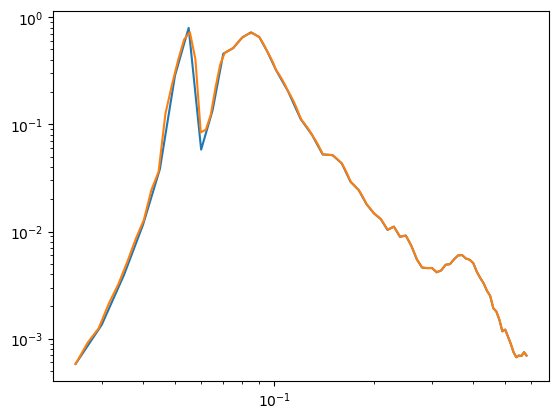

In [6]:
#Load a sample avg spectra

#fname = "/Volumes/TFO-exFAT-1/TFO/LCDRI/CDIPwaverider229/229p1_d01.nc";
fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"
[times, f, spectra] = load_CDIP(fname)
test_spectra = np.mean(spectra[40:50, :], 0)
#f2 = np.logspace(np.log10(0.025), np.log10(0.58), num=256)
f2 = np.linspace(f[0], f[-1], num=256)
spec2 = np.interp(f2, f, test_spectra)
plt.loglog(f, test_spectra)
plt.loglog(f2, spec2)
f = f2
test_spectra = spec2

In [9]:


#Now make a 2-d  velocity grid field from a spectrum
#Assume random phase, and random direction

x_range = np.arange(0, 10, 1)
z_range = np.arange(0, 1, 1)
t_range = np.arange(0, 120, 1)
#xx, zz = np.meshgrid(x_range, z_range)
tt, zzt = np.meshgrid(t_range, z_range)

#tt, xx, zz = np.meshgrid(x_range, z_range, t_range)
#y_range = [0, 100]

#Normally would loop through at each time step and generate a x-z wave field
#Lets start with t=0
n_iter = 500

fs = 1
u_store = np.zeros((n_iter, len(z_range), len(t_range)));

#Number of iterations to run
zeta_store = np.zeros((n_iter, len(t_range)))
df = f[2]-f[1]
t = 0
x = 0
for jj in range(0, n_iter-1):
    for i in range(0, len(f)-1):
        freq = f[i]
        if i==0:
            df = f[1]-f[0]
        elif i == len(f)-1:
            df = f[i]-f[i-1]
        else:
            i
            df = (f[i+1]-f[i-1])/2
            
        omega = 2*np.pi*freq;
        k = np.sqrt(omega/9.8)
        a = np.sqrt(test_spectra[i]*df*2) # Is this the right conversion to wave amplitude? 

        #Randomize phase
        phi = rand.random()*2*np.pi;
        
        #Randomize direction?
        #TO DO: Need to have peak in narrow directional band
        #Should we be able to input directional spectra
        
        u = a*omega*np.cos(k*x-omega*tt + phi)*np.exp(-k*zzt)
        zeta = a*np.cos(k*x-omega*t_range + phi)
        #print(u)
        u_store[jj, :, :] = u_store[jj, :, :] + u
        zeta_store[jj, :] = zeta_store[jj, :] + zeta
#how do we choose the amplitude for each frequency?



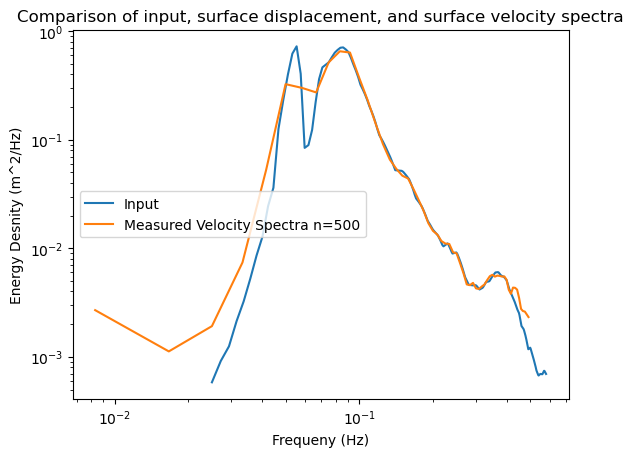

In [10]:
fs = 1
nblock = 120
overlap = 60
win = scipy.signal.windows.hann(nblock, True)
#scipy.hanning(nblock)
fplot, Pxxf = scipy.signal.welch(zeta_store, fs, window=win, noverlap=overlap, nfft=nblock, return_onesided=True)


#Now take the velocity spectra
u_slice = u_store[:, 0, :]
uwindow = np.empty(u_slice.shape);
#print(u_slice.shape)
uwindow = u_slice;
w = len(uwindow[0, :])
#Make the hanning taper
taper_in = np.linspace(1, w, w)*np.pi/w
taper = np.sin(taper_in)
taper_out = np.tile(np.transpose(taper), (u_slice.shape[0], 1))

#Taper the window
uwindowtaper = uwindow * taper_out

#Rescale
factor = np.sqrt(np.var(uwindow)/np.var(uwindowtaper))

uwindowready = uwindowtaper*factor

#Take fft
Uwindow = np.fft.fft(uwindowready)
fwindow = np.fft.fftfreq(uwindowready.shape[-1], d=1/fs)
fwindow=fwindow[:int(w/2)]

Uwindow = np.delete(Uwindow,  np.s_[int(w/2):], 1)


#Remove first entry, make last entry equal to zero?
#NOt sure why Andy does this---Seems to skew the spectrum
#Uwindow = np.delete(Uwindow, 0, 1)
#Uwindow = np.append(Uwindow, np.ones((n_iter, 1)), axis=1)


#Take power spectra

UUwindow = np.real(Uwindow * np.conj(Uwindow))

#Do ensemble mean and then get PSD
UU = np.nanmean(UUwindow, axis=0)/(int(w/2)*fs)


Exx = UU[1:] / (np.square((2*np.pi*fwindow[1:])))

mean_disp_spec = np.mean(Pxxf, axis = 0)
plt.figure()
#plt.loglog(fplot, mean_disp_spec, label='Measured Displacement Spectra n=' + str(n_iter))
plt.loglog(f, test_spectra, label='Input')
plt.loglog(fwindow[1:], Exx, label = 'Measured Velocity Spectra n=' + str(n_iter))
plt.title("Comparison of input, surface displacement, and surface velocity spectra")
plt.ylabel("Energy Desnity (m^2/Hz)")
plt.xlabel("Frequeny (Hz)")
plt.legend()
#plt.xlim([f[0]-0.004, f[-1]+0.01])

In [10]:
UUwindow.shape

(500, 600)

Text(0.5, 1.0, 'Sample surface displacements for 10 realizations')

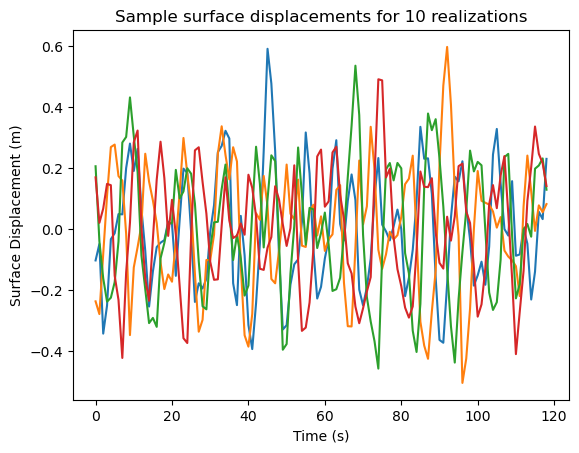

In [6]:
plt.figure()
#plt.plot(np.nanmean(zeta_store, axis=0))
plt.plot(np.transpose(zeta_store[1:5, 1:120]))
plt.xlabel("Time (s)")
plt.ylabel("Surface Displacement (m)")
plt.title("Sample surface displacements for 10 realizations")


In [9]:
## Simulate the EM-APEX float sampling positions

def apex_sampling_grid(t_range, z_offset=0):
    ## Returns the x-coords, t-coords, z-coords of the EM-APEX samples
    ## if len(t_range)==n, then all are length n
    ##
    t_range = np.arange(0, 1000)
    z_range = np.linspace(0, 100, 2000)

    #Em-APEX descent speed
    em_w = 0.1 #0.1m/s

    #Get the z-position
    em_z = t_range*em_w+z_offset
    mean_u = 0.05
    u_prof = np.ones(len(z_range))*mean_u

    #First lest just try a constant mean velocity
    em_x = t_range*mean_u

    ##TO DO:
    #Get the x-position
    #First for each timestep, get the z-position
    #Then get the closest velocity value (Allowing for non-constant velocity profile)
    #vels = get_vel(em_z, u_prof)
    #em_x = 
    
    return(t_range, em_x, em_z)


In [10]:

#Now make a u_store given the sampling parameters, don't build a whole grid


def build_u_timeseries(t_range, em_z, test_spectra, f):

    #Normally would loop through at each time step and generate a x-z wave field
    #Lets start with t=0
    n_iter = 500

    fs = 1
    u_store = np.zeros((n_iter, len(t_range)));

    #Number of iterations to run
    #zeta_store = np.zeros((n_iter, len(t_range)))
    t = 0
    x = 0
    for jj in range(0, n_iter-1):
        for i in range(0, len(f-1)):#:#len(f)-1:
            freq = f[i]
            if i == 0:
                df = f[1]-f[0]
            elif i == len(f)-1:
                df = f[i]-f[i-1]
            else:
                i
                df = (f[i+1]-f[i-1])/2
            omega = 2*np.pi*freq;
            k = np.sqrt(omega/9.8)
            a = np.sqrt(test_spectra[i]*df*2) # Is this the right conversion to wave amplitude? 

            #Randomize phase
            phi = rand.random()*2*np.pi;

            #Randomize direction?
            #TO DO: Need to have peak in narrow directional band
            #Should we be able to input directional spectra

            u = a*omega*np.cos(k*em_x-omega*t_range + phi)*np.exp(-k*em_z)
            #zeta = a*np.cos(k*x-omega*t_range + phi)
            #print(u)
            u_store[jj, :] = u_store[jj, :] + u
            #zeta_store[jj, :] = zeta_store[jj, :] + zeta
    #how do we choose the amplitude for each frequency?



    ## Add white noise
    
    #First generate a white noise with the std of an EM-APEX float white noise situation
    #TO DO: Check if "uncertainty of 0.8-1.5 cm/s" means that's 1 Std or rms or what
    mean = 0
    std = 0.01 
    num_samples = len(u_store[:, 0])*len(u_store[0, :])
    rand_samples = 0.008*np.random.normal(loc = 0, scale = 1, size = num_samples)


#     #Plot spectra of u_noise
#     #plt.plot(rand_samples)

#     ff = np.fft.fft(rand_samples)
#     ff_freq = np.fft.fftfreq(rand_samples.shape[-1], d=1)
#     ff_freq=ff_freq[:int(len(rand_samples)/2)]
#     ff = np.delete(ff,  np.s_[int(len(rand_samples)/2):], 0)
#     ff_power = np.real(ff * np.conj(ff))

#     #Do ensemble mean and then get PSD
#     #UU = np.nanmean(np.nanmean(UUwindow, axis=1), axis=0)/(int(w/2)*fs)

    
#     ff = np.fft.fft(rand_samples)
#     ff_freq = np.fft.fftfreq(rand_samples.shape[-1], d=1)
#     ff_freq=ff_freq[:int(len(rand_samples)/2)]
#     ff = np.delete(ff,  np.s_[int(len(rand_samples)/2):], 1)
#     ff_power = np.real(ff * np.conj(ff))
#     ff_power = np.nanmean(ff_power, 0)
#     ff_en = ff_power[1:] / (np.square((2*np.pi*ff_freq[1:])))
#     plt.loglog(ff_freq[1:], ff_en)
#     plt.show()

#     print(ff_freq.shape)
#     print(ff.shape)



    #
    rand_samples = rand_samples.reshape((len(u_store[:, 0]), len(u_store[0, :])))
    u_noise = u_store + rand_samples
    
    return(u_store, u_noise)

In [11]:

#Reshape the data into 120s chunks etc for taking spectra
#Here I'm doing it with a 50% overlap

def reshape_u(u, em_z, nblock, overlap, fs):
    """
    Input:
        u: array of 1Hz velocity data
        nblock: Windo length for calculating spectra
        overalp: number of samples to overlap. E.G. if nblock = 120, overlap = 60 is 50% overlap, overlap = 30 is 25% overlap
        fs: sampling frequency (should be 1Hz for EM-APEX)
        
    Output: 
        u_new:
        z_new
    """
    
    #fs = 1
    #nblock = 120
    #nstep = 60 #50% overlap?
   # overlap = 60
    

    slide = nblock-overlap
    num_of_blocks = (len(u[1, :])//slide)-1
    #First need to rearrange the velocities into the 120s chunks w/ 50% overlap 
    nout = 0

    u_new = np.empty((n_iter, num_of_blocks,nblock))
    #u_new_noise = np.empty((n_iter, num_of_blocks,nblock))
    z_new = np.empty((num_of_blocks, nblock))
    for i1 in range(0, len(u[1, :])-nblock, slide):
        j = list(range(i1, i1+nblock))

        u_new[:, nout, :] = u[:, j]
        #u_new_noise[:, nout, :] = u_noise[:, j]

        #Should maybe I tile em_z here to make it same dims as u_new?
        z_new[nout, :] = em_z[j]
        nout = nout+1  
    
    #print(u_new.shape)
    return(u_new, z_new)

In [ ]:
## Test Reshape_u
t_r = np.arange(0, 1000)
[t_range, em_x, em_z] = apex_sampling_grid(t_r)
[u_out, z_out] = reshape_u(u_store, em_z, 300, 150, 1)
u_out.shape

In [12]:


def make_vel_spectrum(u_new):
    """
    Input
        u_new: numpy array of velocity profile reshaped into matrix with dims [#wave-simulations, #windows, length of window]
    output:
        Exx: Energy density spectrum in m^2/Hz
    
    """

    #Define window taper
    win = scipy.signal.windows.hann(nblock, True)
    
    #Now take the velocity spectra
    uwindow = u_new;
    #print(u_new.shape)
    #uwindow = u_slice;
    w = len(uwindow[0, 0, :])
    #Make the hanning taper
    taper_in = np.linspace(1, w, w)*np.pi/w
    taper = np.sin(taper_in)
    taper_out = np.tile(np.transpose(taper), (u_new.shape[0], u_new.shape[1], 1))

    #Taper the window
    uwindowtaper = uwindow * taper_out

    #print(uwindowtaper.shape)

    #Rescale
    factor = np.sqrt(np.var(uwindow)/np.var(uwindowtaper))

    uwindowready = uwindowtaper*factor

    #Take fft
    Uwindow = np.fft.fft(uwindowready)
    fwindow = np.fft.fftfreq(uwindowready.shape[-1], d=1/fs)
    fwindow=fwindow[:int(w/2)]

    Uwindow = np.delete(Uwindow,  np.s_[int(w/2):], 2)



    #Remove first entry, make last entry equal to zero?
    #NOt sure why Andy does this---Seems to skew the spectrum
    #Uwindow = np.delete(Uwindow, 0, 1)
    #Uwindow = np.append(Uwindow, np.ones((n_iter, 1)), axis=1)


    #Take power spectra

    UUwindow = np.real(Uwindow * np.conj(Uwindow))

    #Do ensemble mean and then get PSD
    #UU = np.nanmean(np.nanmean(UUwindow, axis=1), axis=0)/(int(w/2)*fs)


    #Exx = UU[1:] / (np.square((2*np.pi*fwindow[1:])))
    return(UUwindow, fwindow)



def depth_correct_Eric(UUwindow, fwindow, em_z, w, Cmax):
    """
    Returns spectra modified by D'Asaro 2015 depth correction
    
    """
    
    
   

    k_array = np.sqrt(2*np.pi*fwindow/9.8);
    k_mat = np.tile(k_array, (UUwindow.shape[0], UUwindow.shape[1], 1))
    
    #This is def not the easiest way to do this
    z_mat = np.tile(em_z, (UUwindow.shape[0], 1, 1))
    z_mat = np.tile(np.expand_dims(np.nanmean(z_mat, axis=2), axis=2), (1, 1, len(k_mat[0, 0, :])))
    
    
    depth_fact = np.exp(2*k_mat*z_mat)
    depth_fact[depth_fact>Cmax]=np.nan
    UUwindow_out = np.nanmean(UUwindow, axis=0)*depth_fact

    
    
    return(UUwindow_out)

def depth_correct_Andy(UUwindow, fwindow, em_z, w, Cmax):
    """
    Returns spectra modified by Hsu 2021 depth correction
 
    """
    c = 0.06
    T0 = 120
    k_array = np.sqrt(2*np.pi*fwindow/9.8);
    k_mat = np.tile(k_array, (UUwindow.shape[0], UUwindow.shape[1], 1))
    
    #This is def not the easiest way to do this
    z_mat = np.tile(em_z, (UUwindow.shape[0], 1, 1))
    z_mat = np.tile(np.expand_dims(np.nanmean(z_mat, axis=2), axis=2), (1, 1, len(k_mat[0, 0, :])))
    
    depth_fact = np.exp(2*k_mat*(1+c*np.exp(-w/T0+1))*z_mat)
    depth_fact[depth_fact>Cmax]=np.nan
    UUwindow_out = np.nanmean(UUwindow, axis=0)*depth_fact

    
    return(UUwindow_out)

def depth_correct_James(UUwindow, fwindow, em_z, w, Cmax, zeta=1/2):
    """
    Returns spectra modified by my 1/2 energy depth correction
    
    """
    
    k_array = np.sqrt(2*np.pi*fwindow/9.8);
    k_mat = np.tile(k_array, (UUwindow.shape[0], UUwindow.shape[1], 1))
    
    #This is def not the easiest way to do this
    z_mat = np.tile(em_z, (UUwindow.shape[0], 1, 1))    
    z_window_0 = z_mat[:, :, 0]
    z_mat_0 = np.tile(np.expand_dims(z_window_0, axis=2), (1, 1, len(k_mat[0, 0, :])))
    
    
    #Try the z depth I derive based on 1/2 wave energy
    dz = -1/(2*k_mat)*np.log((1/2)*np.exp(-2*k_mat*(0.1)*w)+(1-zeta))
    z = z_mat_0+dz
    depth_fact_new = np.exp(2*k_mat*(z_mat_0+dz))
    
    depth_fact_new[depth_fact_new>Cmax]=np.nan
    
    
    UUwindow_out = np.nanmean(UUwindow, axis=0)*depth_fact_new
    
    return(UUwindow_out)


In [88]:
def sig_wave_height(f, spec):
    """
    Input
        f: frequencies
        spec: energy density spectra to integrate
        
        
    Output
        swh: Significant Wave Height calculated by integrating the input spectra
    
    """
    
    
    ##Need to remove Nan's
    real_inds = np.argwhere(~np.isnan(spec))
    
    spec = spec[real_inds]
    f = f[real_inds]
    swh = 4*np.sqrt(np.trapz(spec[:, 0], x=f[:, 0]))
    return(swh)
    

In [89]:
#Test sig_wave_height

sig_wave_height(fwindow[1:], Exx2_noise)

1.5549612584611294

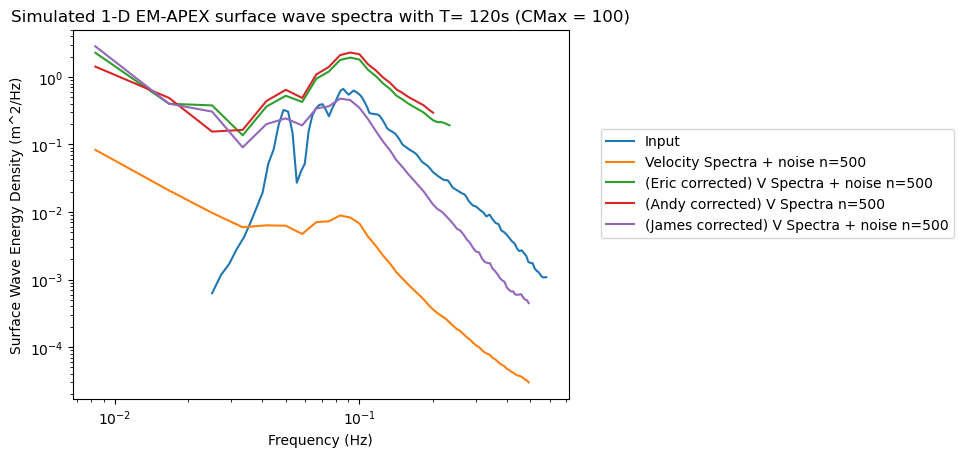

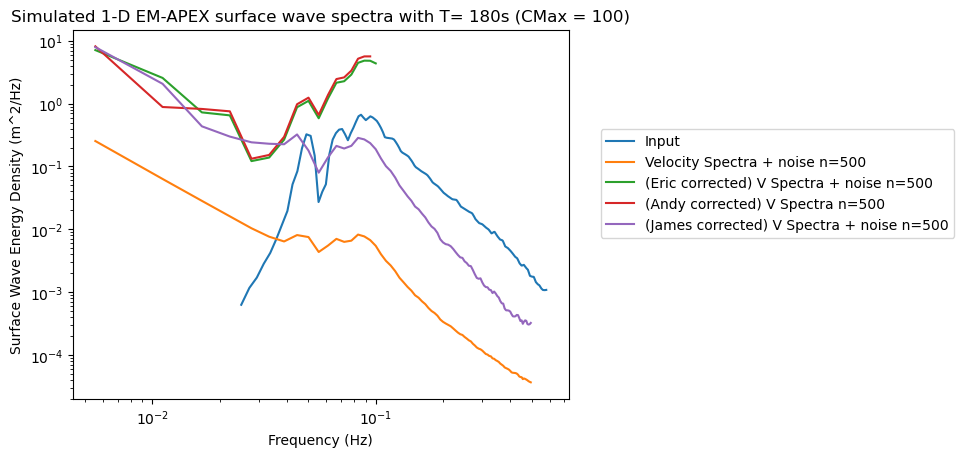

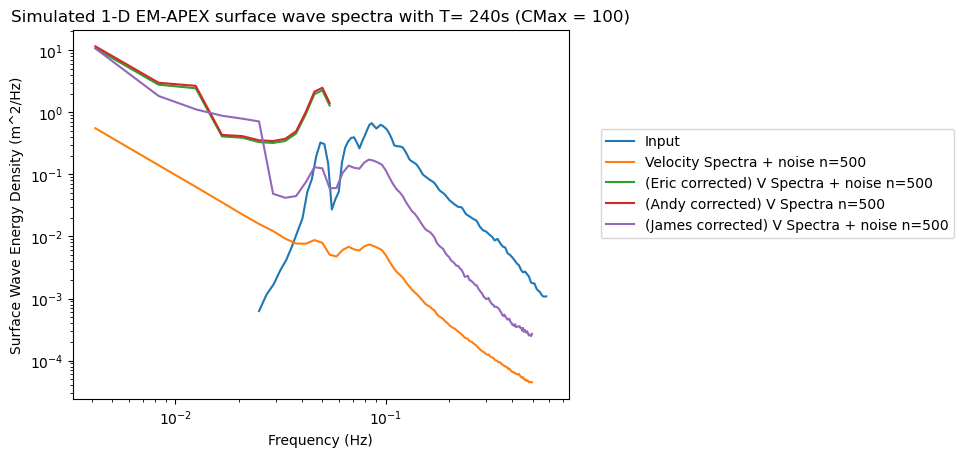

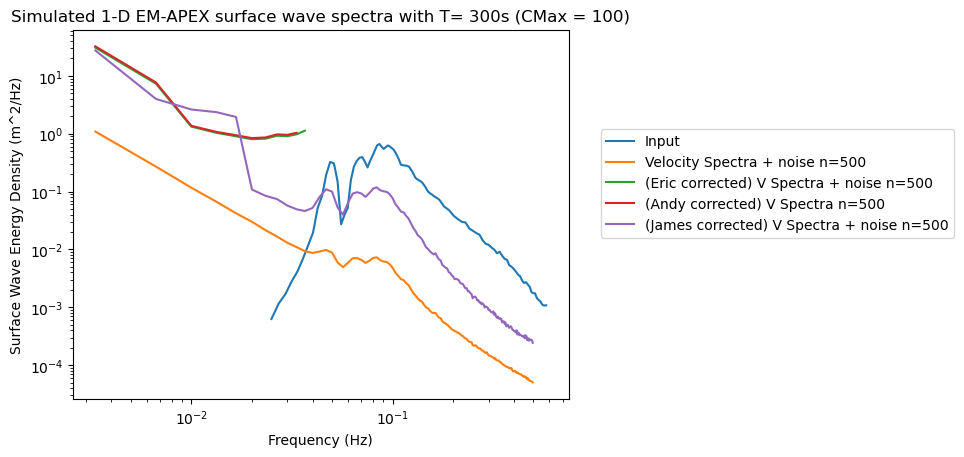

In [13]:
### Caclulate Spectral impact of varying window length
import warnings
warnings.filterwarnings('ignore')

block_l = [120, 180, 240, 300]
for nblock in block_l:
    
    #nblock = 120
    overlap = int(nblock/2)
    fs = 1
    Cmax = 100
    w = nblock


    #Em-APEX Sampling Grid
    t_range = np.arange(0, 1000)
    t_range, em_x, em_z = apex_sampling_grid(t_range)

    #build the u-time-series
    [u_store, u_noise] = build_u_timeseries(t_range, em_z, test_spectra, f)

    #Reshape the u time series
    [u_new, z_new] = reshape_u(u_store, em_z, nblock, overlap, fs)
    [u_new_noise, z_new] = reshape_u(u_noise, em_z, nblock, overlap, fs)


    #Make the actual spectra by calling the function above
    UUwindow, fwindow= make_vel_spectrum(u_new)
    UUwindow_noise, fwindow = make_vel_spectrum(u_new_noise)



    ### Now try doing the depth correction as the first order correction from D'asaro
    #UUwindow2 = depth_correct_Eric(UUwindow, fwindow, z_new, nblock, Cmax)
    UUwindow2_noise = depth_correct_Eric(UUwindow_noise, fwindow, z_new, nblock, Cmax)

    ##Now apply Andy Depth correction
    #UUwindow_A = depth_correct_Andy(UUwindow, fwindow, z_new, nblock, Cmax)
    UUwindow_A_noise = depth_correct_Andy(UUwindow_noise, fwindow, z_new, nblock, Cmax)


    ##Now apply my depth correction
    #UUwindow3 = depth_correct_James(UUwindow, fwindow, z_new, nblock, Cmax, 3/4)
    zeta = 0.8
    UUwindow3_noise = depth_correct_James(UUwindow_noise, fwindow, z_new, nblock, Cmax, zeta)


    #Compute the raw Energy Density Spectra
    #UU = np.nanmean(np.nanmean(UUwindow, axis=0), axis=0)/(int(w/2)*fs)
    UU_noise = np.nanmean(np.nanmean(UUwindow_noise, axis=0), axis=0)/(int(w/2)*fs)
    #Exx = UU[1:]/ (np.square((2*np.pi*fwindow[1:])))
    Exx_noise = UU_noise[1:]/ (np.square((2*np.pi*fwindow[1:])))


    #Compute Eric Energy Density Spectra
    #UU2 = np.nanmean(np.nanmean(UUwindow2, axis=0), axis=0)/(int(w/2)*fs)
    UU2_noise = np.nanmean(np.nanmean(UUwindow2_noise, axis=0), axis=0)/(int(w/2)*fs)
    #Exx2 = UU2[1:] / (np.square((2*np.pi*fwindow[1:])))
    Exx2_noise = UU2_noise[1:] / (np.square((2*np.pi*fwindow[1:])))


    #Compute Andy Energy Density Spectra
    #UU_A = np.nanmean(np.nanmean(UUwindow_A, axis=0), axis=0)/(int(w/2)*fs)
    UU_A_noise = np.nanmean(np.nanmean(UUwindow_A_noise, axis=0), axis=0)/(int(w/2)*fs)
    #Exx_A = UU_A[1:] / (np.square((2*np.pi*fwindow[1:])))
    Exx_A_noise = UU_A_noise[1:] / (np.square((2*np.pi*fwindow[1:])))



    #Compute James Energy Density Spectra
    #UU3 = np.nanmean(np.nanmean(UUwindow3, axis=0), axis=0)/(int(w/2)*fs)
    UU3_noise = np.nanmean(np.nanmean(UUwindow3_noise, axis=0), axis=0)/(int(w/2)*fs)
    #Exx3 = UU3[1:] / (np.square((2*np.pi*fwindow[1:])))
    Exx3_noise = UU3_noise[1:] / (np.square((2*np.pi*fwindow[1:])))


    plt.figure()
    plt.loglog(f, test_spectra, label='Input')
    #plt.loglog(fwindow[1:], Exx, label = 'Velocity Spectra n=' + str(n_iter))
    plt.loglog(fwindow[1:], Exx_noise, label = 'Velocity Spectra + noise n=' + str(n_iter))


    #plt.loglog(fwindow[1:], Exx2, label = '(Eric corrected) V Spectra n=' + str(n_iter))
    plt.loglog(fwindow[1:], Exx2_noise, label = '(Eric corrected) V Spectra + noise n=' + str(n_iter))

    plt.loglog(fwindow[1:], Exx_A_noise, label = '(Andy corrected) V Spectra n=' + str(n_iter))

    plt.loglog(fwindow[1:], Exx3_noise, label = '(James corrected) V Spectra + noise n=' + str(n_iter))




    plt.legend(bbox_to_anchor=(1.05, 0.75))

    plt.title("Simulated 1-D EM-APEX surface wave spectra with T= " + str(nblock)+"s (CMax = "+str(Cmax)+")")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Surface Wave Energy Density (m^2/Hz)")

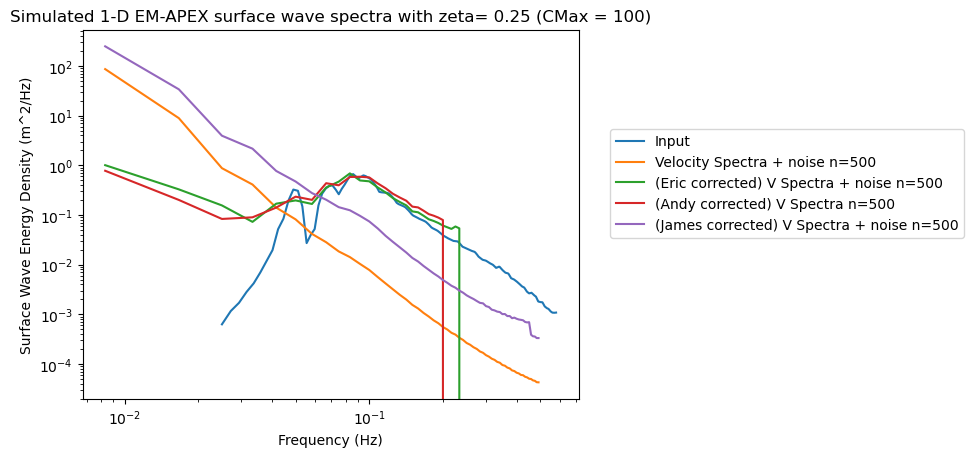

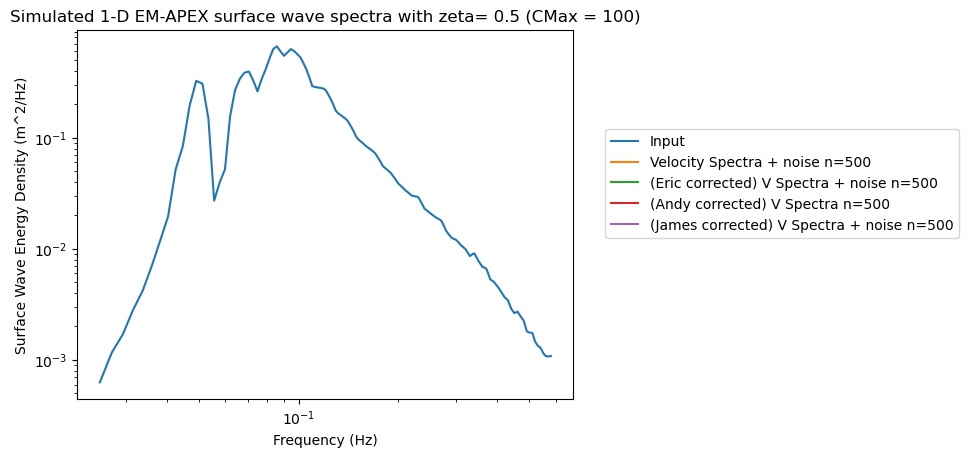

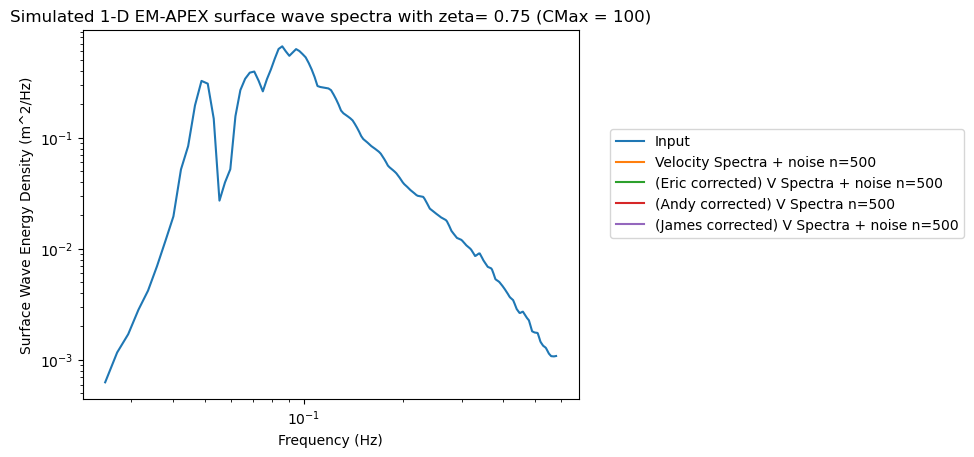

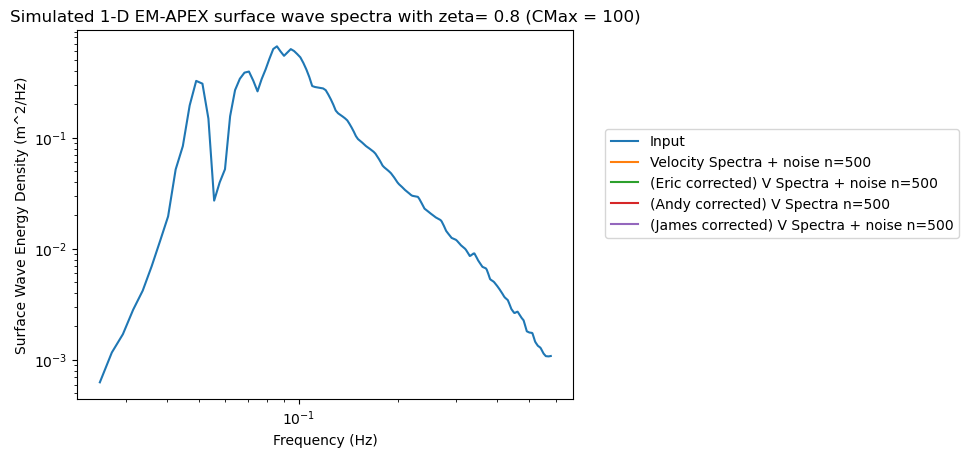

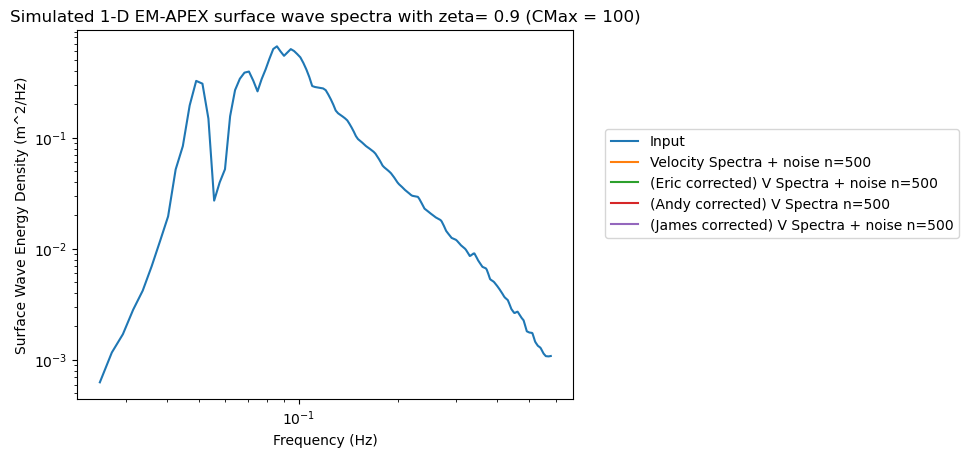

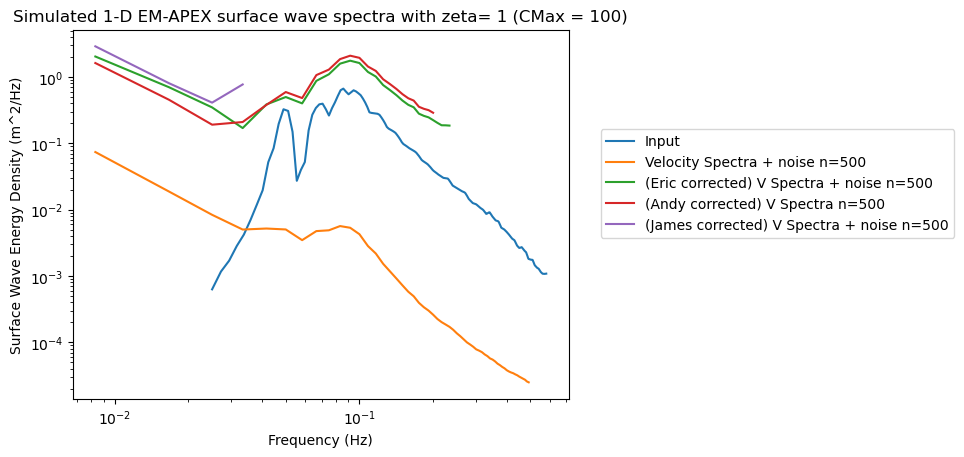

In [93]:
### Caclulate Spectral impact of varying zeta 
import warnings
warnings.filterwarnings('ignore')


swhs = pd.DataFrame(columns=['Zetas', 'Input','Raw', 'Eric', 'Andy', 'James'])
input_swh = sig_wave_height(f, test_spectra)
zetas = [0.25, 0.5, 0.75, 0.8, 0.9, 1]
for zeta in zetas:
    
    nblock = 120
    overlap = int(nblock/2)
    overlap = 80
    fs = 1
    Cmax = 100
    w = nblock


    #Em-APEX Sampling Grid
    t_range = np.arange(0, 1000)
    t_range, em_x, em_z = apex_sampling_grid(t_range)

    #build the u-time-series
    [u_store, u_noise] = build_u_timeseries(t_range, em_z, test_spectra, f)

    #Reshape the u time series
    [u_new, z_new] = reshape_u(u_store, em_z, nblock, overlap, fs)
    [u_new_noise, z_new] = reshape_u(u_noise, em_z, nblock, overlap, fs)


    #Make the actual spectra by calling the function above
    UUwindow, fwindow= make_vel_spectrum(u_new)
    UUwindow_noise, fwindow = make_vel_spectrum(u_new_noise)



    ### Now try doing the depth correction as the first order correction from D'asaro
    #UUwindow2 = depth_correct_Eric(UUwindow, fwindow, z_new, nblock, Cmax)
    UUwindow2_noise = depth_correct_Eric(UUwindow_noise, fwindow, z_new, nblock, Cmax)

    ##Now apply Andy Depth correction
    #UUwindow_A = depth_correct_Andy(UUwindow, fwindow, z_new, nblock, Cmax)
    UUwindow_A_noise = depth_correct_Andy(UUwindow_noise, fwindow, z_new, nblock, Cmax)


    ##Now apply my depth correction
    #UUwindow3 = depth_correct_James(UUwindow, fwindow, z_new, nblock, Cmax, 3/4)
    UUwindow3_noise = depth_correct_James(UUwindow_noise, fwindow, z_new, nblock, Cmax, zeta)


    #Compute the raw Energy Density Spectra
    #UU = np.nanmean(np.nanmean(UUwindow, axis=0), axis=0)/(int(w/2)*fs)
    UU_noise = np.nanmean(np.nanmean(UUwindow_noise, axis=0), axis=0)/(int(w/2)*fs)
    #Exx = UU[1:]/ (np.square((2*np.pi*fwindow[1:])))
    Exx_noise = UU_noise[1:]/ (np.square((2*np.pi*fwindow[1:])))
    raw_swh= sig_wave_height(fwindow[1:], Exx_noise)

    #Compute Eric Energy Density Spectra
    #UU2 = np.nanmean(np.nanmean(UUwindow2, axis=0), axis=0)/(int(w/2)*fs)
    UU2_noise = np.nanmean(np.nanmean(UUwindow2_noise, axis=0), axis=0)/(int(w/2)*fs)
    #Exx2 = UU2[1:] / (np.square((2*np.pi*fwindow[1:])))
    Exx2_noise = UU2_noise[1:] / (np.square((2*np.pi*fwindow[1:])))
    Eric_swh = sig_wave_height(fwindow[1:], Exx2_noise)

    #Compute Andy Energy Density Spectra
    #UU_A = np.nanmean(np.nanmean(UUwindow_A, axis=0), axis=0)/(int(w/2)*fs)
    UU_A_noise = np.nanmean(np.nanmean(UUwindow_A_noise, axis=0), axis=0)/(int(w/2)*fs)
    #Exx_A = UU_A[1:] / (np.square((2*np.pi*fwindow[1:])))
    Exx_A_noise = UU_A_noise[1:] / (np.square((2*np.pi*fwindow[1:])))
    Andy_swh = sig_wave_height(fwindow[1:], Exx_A_noise)


    #Compute James Energy Density Spectra
    #UU3 = np.nanmean(np.nanmean(UUwindow3, axis=0), axis=0)/(int(w/2)*fs)
    UU3_noise = np.nanmean(np.nanmean(UUwindow3_noise, axis=0), axis=0)/(int(w/2)*fs)
    #Exx3 = UU3[1:] / (np.square((2*np.pi*fwindow[1:])))
    Exx3_noise = UU3_noise[1:] / (np.square((2*np.pi*fwindow[1:])))
    James_swh= sig_wave_height(fwindow[1:], Exx3_noise)

    
    #Put the swh's in the dataframe
    
    df2 = pd.DataFrame(data = [[zeta, input_swh, raw_swh, Eric_swh, Andy_swh, James_swh]], columns=['Zetas', 'Input', 'Raw', 'Eric', 'Andy', 'James'])
    swhs = swhs.append(df2, ignore_index=True)
    
    
    plt.figure()
    plt.loglog(f, test_spectra, label='Input')
    #plt.loglog(fwindow[1:], Exx, label = 'Velocity Spectra n=' + str(n_iter))
    plt.loglog(fwindow[1:], Exx_noise, label = 'Velocity Spectra + noise n=' + str(n_iter))


    #plt.loglog(fwindow[1:], Exx2, label = '(Eric corrected) V Spectra n=' + str(n_iter))
    plt.loglog(fwindow[1:], Exx2_noise, label = '(Eric corrected) V Spectra + noise n=' + str(n_iter))

    plt.loglog(fwindow[1:], Exx_A_noise, label = '(Andy corrected) V Spectra n=' + str(n_iter))

    plt.loglog(fwindow[1:], Exx3_noise, label = '(James corrected) V Spectra + noise n=' + str(n_iter))




    plt.legend(bbox_to_anchor=(1.05, 0.75))

    plt.title("Simulated 1-D EM-APEX surface wave spectra with zeta= " + str(zeta)+" (CMax = "+str(Cmax)+")")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Surface Wave Energy Density (m^2/Hz)")

In [91]:
swhs

,Zetas,Input,Raw,Eric,Andy,James
0,0.25,0.794876,0.144404,1.553272,1.626216,0.654843
1,0.50,0.794876,0.144092,1.554192,1.628445,0.694020
2,0.75,0.794876,0.144707,1.561763,1.638867,0.877653
3,0.80,0.794876,0.144024,1.552035,1.624612,0.911346
4,0.90,0.794876,0.143985,1.544993,1.619740,1.195561
5,1.00,0.794876,0.143554,1.544031,1.619001,0.685328


In [66]:
inds = np.argwhere(~np.isnan(Exx2_noise))
Exx2_noise[inds].shape
f_test = fwindow[1:]
f_test[inds].shape

(28, 1)

Text(0, 0.5, 'Surface Wave Energy Density (m^2/Hz)')

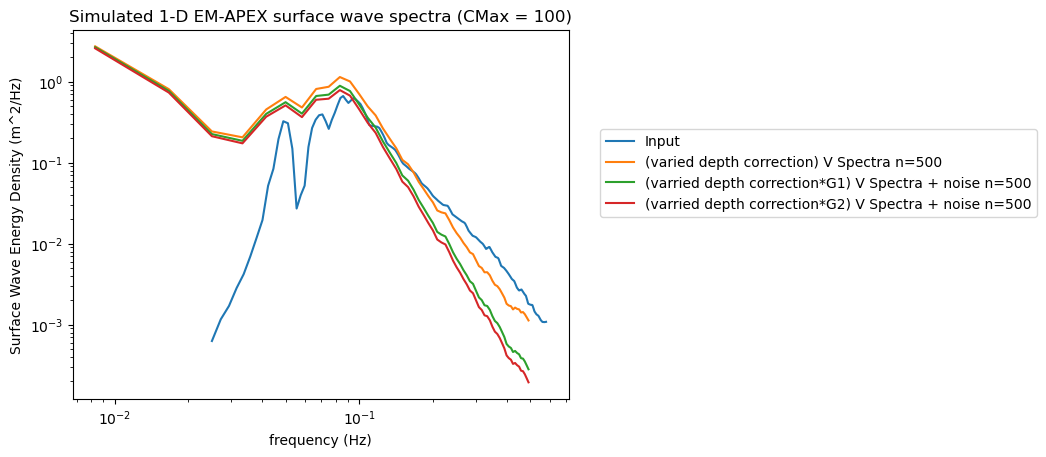

In [38]:
#Ok now lets try applying the Eric D'Asaro kWT motion correction for zeta = 0.9, T=300s and see how close we get...


zeta=0.75
nblock = 120
overlap = 60
fs = 1
Cmax = 100
w = nblock


#Em-APEX Sampling Grid
t_range = np.arange(0, 1000)
t_range, em_x, em_z = apex_sampling_grid(t_range)

#build the u-time-series
[u_store, u_noise] = build_u_timeseries(t_range, em_z, test_spectra, f)

#Reshape the u time series
[u_new, z_new] = reshape_u(u_store, em_z, nblock, overlap, fs)
[u_new_noise, z_new] = reshape_u(u_noise, em_z, nblock, overlap, fs)


#Make the actual spectra by calling the function above
UUwindow, fwindow= make_vel_spectrum(u_new)
UUwindow_noise, fwindow = make_vel_spectrum(u_new_noise)



##Now apply my depth correction
UUwindow3 = depth_correct_James(UUwindow, fwindow, z_new, nblock, Cmax, 0.9)
UUwindow3_noise = depth_correct_James(UUwindow_noise, fwindow, z_new, nblock, Cmax, 0.9)




#Compute James Energy Density Spectra
UU3 = np.nanmean(np.nanmean(UUwindow3, axis=0), axis=0)/(int(w/2)*fs)
UU3_noise = np.nanmean(np.nanmean(UUwindow3_noise, axis=0), axis=0)/(int(w/2)*fs)
Exx3 = UU3[1:] / (np.square((2*np.pi*fwindow[1:])))
Exx3_noise = UU3_noise[1:] / (np.square((2*np.pi*fwindow[1:])))

#### Now try applying the motion correction gain adjustment from D'Asaro 2015

k_array = np.sqrt(2*np.pi*fwindow/9.8);
k_mat = np.tile(k_array, (UUwindow.shape[0], UUwindow.shape[1], 1))
kWT = 1*k_mat*0.1*w
G = np.square((np.square(np.pi)/(np.square(kWT/2)+np.square(np.pi)))*(np.sinh(kWT/2)/(kWT/2)))
UUwindow3_G1 = UUwindow3_noise/ G

### Try the 1s sampling correction
d1 = 0.004897
d2 = 0.033609
d3 = 0.999897
G2 = d1*np.square(kWT)+d2*kWT+d3
UUwindow3_G2 = UUwindow3_G1/G2

###Now the final correction
dw = 2*np.pi/nblock
omega_mat = np.tile(2*np.pi*fwindow, (UUwindow.shape[0], UUwindow.shape[1], 1))
h=0.25
z_mat = np.tile(z_new, (UUwindow.shape[0], 1, 1))
z_mat = np.tile(np.expand_dims(np.nanmean(z_mat, axis=2), axis=2), (1, 1, len(k_mat[0, 0, :])))

G3 = 1/np.square(1+2*h*(np.cosh((2*omega*dw+np.square(dw)*z_mat)/9.8)-1))

UUwindow3_G3 = UUwindow3_G2*G3
#UUwindow3_G =  np.divide(UUwindow2_noise, G)
#UU3 = np.nanmean(np.nanmean(UUwindow3, axis=0), axis=0)/(int(w/2)*fs)
UU3_G3 = np.nanmean(np.nanmean(UUwindow3_G3, axis=0), axis=0)/(int(w/2)*fs)
UU3_G2 = np.nanmean(np.nanmean(UUwindow3_G2, axis=0), axis=0)/(int(w/2)*fs)
UU3_G1 = np.nanmean(np.nanmean(UUwindow3_G1, axis=0), axis=0)/(int(w/2)*fs)
#Exx3 = UU3[1:] / (np.square((2*np.pi*fwindow[1:])))
Exx3_G3 = UU3_G3[1:] / (np.square((2*np.pi*fwindow[1:])))
Exx3_G2 = UU3_G2[1:] / (np.square((2*np.pi*fwindow[1:])))
Exx3_G1 = UU3_G1[1:] / (np.square((2*np.pi*fwindow[1:])))





mean_disp_spec = np.mean(Pxxf, axis = 0)
plt.figure()
#plt.loglog(fplot, mean_disp_spec, label='Displacement Spectra n=' + str(n_iter))
plt.loglog(f, test_spectra, label='Input')
#plt.loglog(fwindow[1:], Exx, label = 'Velocity Spectra n=' + str(n_iter))
#lt.loglog(fwindow[1:], Exx_noise, label = 'Velocity Spectra + noise n=' + str(n_iter))


#plt.loglog(fwindow[1:], Exx2, label = '(Eric corrected) V Spectra n=' + str(n_iter))
#plt.loglog(fwindow[1:], Exx2_noise, label = '(depth corrected) V Spectra + noise n=' + str(n_iter))

#plt.loglog(fwindow[1:], Exx_A, label = '(Andy corrected) V Spectra n=' + str(n_iter))

plt.loglog(fwindow[1:], Exx3_noise, label = '(varied depth correction) V Spectra n=' + str(n_iter))
#plt.loglog(fwindow[1:], Exx3_noise, label = '(varried depth correction) V Spectra + noise n=' + str(n_iter))
plt.loglog(fwindow[1:], Exx3_G1, label = '(varried depth correction*G1) V Spectra + noise n=' + str(n_iter))
plt.loglog(fwindow[1:], Exx3_G2, label = '(varried depth correction*G2) V Spectra + noise n=' + str(n_iter))
#plt.loglog(fwindow[1:], Exx3_G3, label = '(varried depth correction*G3) V Spectra + noise n=' + str(n_iter))





plt.legend(bbox_to_anchor=(1.05, 0.75))

plt.title("Simulated 1-D EM-APEX surface wave spectra (CMax = 100)")
plt.xlabel("frequency (Hz)")
plt.ylabel("Surface Wave Energy Density (m^2/Hz)")



In [ ]:
### Script to actually calculate spectra

zeta
nblock = 120
overlap = 60
fs = 1
Cmax = 100
w = nblock


#Em-APEX Sampling Grid
t_range = np.arange(0, 1000)
t_range, em_x, em_z = apex_sampling_grid(t_range)

#build the u-time-series
[u_store, u_noise] = build_u_timeseries(t_range, em_z, test_spectra, f)

#Reshape the u time series
[u_new, z_new] = reshape_u(u_store, em_z, nblock, overlap, fs)
[u_new_noise, z_new] = reshape_u(u_noise, em_z, nblock, overlap, fs)


#Make the actual spectra by calling the function above
UUwindow, fwindow= make_vel_spectrum(u_new)
UUwindow_noise, fwindow = make_vel_spectrum(u_new_noise)





### Now try doing the depth correction as the first order correction from D'asaro
UUwindow2 = depth_correct_Eric(UUwindow, fwindow, z_new, nblock, Cmax)
UUwindow2_noise = depth_correct_Eric(UUwindow_noise, fwindow, z_new, nblock, Cmax)

##Now apply Andy Depth correction
UUwindow_A = depth_correct_Andy(UUwindow, fwindow, z_new, nblock, Cmax)
UUwindow_A_noise = depth_correct_Andy(UUwindow_noise, fwindow, z_new, nblock, Cmax)



##Now apply my depth correction
UUwindow3 = depth_correct_James(UUwindow, fwindow, z_new, nblock, Cmax, 3/4)
UUwindow3_noise = depth_correct_James(UUwindow_noise, fwindow, z_new, nblock, Cmax, 3/4)



#Compute the raw Energy Density Spectra
UU = np.nanmean(np.nanmean(UUwindow, axis=0), axis=0)/(int(w/2)*fs)
UU_noise = np.nanmean(np.nanmean(UUwindow_noise, axis=0), axis=0)/(int(w/2)*fs)
Exx = UU[1:]/ (np.square((2*np.pi*fwindow[1:])))
Exx_noise = UU_noise[1:]/ (np.square((2*np.pi*fwindow[1:])))



#Compute Eric Energy Density Spectra
UU2 = np.nanmean(np.nanmean(UUwindow2, axis=0), axis=0)/(int(w/2)*fs)
UU2_noise = np.nanmean(np.nanmean(UUwindow2_noise, axis=0), axis=0)/(int(w/2)*fs)
Exx2 = UU2[1:] / (np.square((2*np.pi*fwindow[1:])))
Exx2_noise = UU2_noise[1:] / (np.square((2*np.pi*fwindow[1:])))


#Compute Andy Energy Density Spectra
UU_A = np.nanmean(np.nanmean(UUwindow_A, axis=0), axis=0)/(int(w/2)*fs)
UU_A_noise = np.nanmean(np.nanmean(UUwindow_A_noise, axis=0), axis=0)/(int(w/2)*fs)
Exx_A = UU_A[1:] / (np.square((2*np.pi*fwindow[1:])))
Exx_A_noise = UU_A_noise[1:] / (np.square((2*np.pi*fwindow[1:])))



#Compute James Energy Density Spectra
UU3 = np.nanmean(np.nanmean(UUwindow3, axis=0), axis=0)/(int(w/2)*fs)
UU3_noise = np.nanmean(np.nanmean(UUwindow3_noise, axis=0), axis=0)/(int(w/2)*fs)
Exx3 = UU3[1:] / (np.square((2*np.pi*fwindow[1:])))
Exx3_noise = UU3_noise[1:] / (np.square((2*np.pi*fwindow[1:])))

#### Now try applying the motion correction gain adjustment from D'Asaro 2015

k_array = np.sqrt(2*np.pi*fwindow/9.8);
k_mat = np.tile(k_array, (UUwindow.shape[0], UUwindow.shape[1], 1))
kWT = -1*k_mat*0.1*120
G = np.square((np.square(np.pi)/(np.square(kWT/2)+np.square(np.pi)))*(np.sinh(kWT/2)/(kWT/2)))
#UUwindow3 = UUwindow3* G
#UUwindow3_noise =  np.divide(UUwindow2_noise, G)
UU3 = np.nanmean(np.nanmean(UUwindow3, axis=0), axis=0)/(int(w/2)*fs)
UU3_noise = np.nanmean(np.nanmean(UUwindow3_noise, axis=0), axis=0)/(int(w/2)*fs)
Exx3 = UU3[1:] / (np.square((2*np.pi*fwindow[1:])))
Exx3_noise = UU3_noise[1:] / (np.square((2*np.pi*fwindow[1:])))

mean_disp_spec = np.mean(Pxxf, axis = 0)
plt.figure()
#plt.loglog(fplot, mean_disp_spec, label='Displacement Spectra n=' + str(n_iter))
plt.loglog(f, test_spectra, label='Input')
plt.loglog(fwindow[1:], Exx, label = 'Velocity Spectra n=' + str(n_iter))
plt.loglog(fwindow[1:], Exx_noise, label = 'Velocity Spectra + noise n=' + str(n_iter))


plt.loglog(fwindow[1:], Exx2, label = '(Eric corrected) V Spectra n=' + str(n_iter))
#plt.loglog(fwindow[1:], Exx2_noise, label = '(depth corrected) V Spectra + noise n=' + str(n_iter))

plt.loglog(fwindow[1:], Exx_A, label = '(Andy corrected) V Spectra n=' + str(n_iter))

plt.loglog(fwindow[1:], Exx3, label = '(varied depth correction) V Spectra n=' + str(n_iter))
plt.loglog(fwindow[1:], Exx3_noise, label = '(varried depth correction) V Spectra + noise n=' + str(n_iter))




plt.legend(bbox_to_anchor=(1.05, 0.75))

plt.title("Simulated 1-D EM-APEX surface wave spectra (CMax = 100)")
plt.xlabel("frequency (Hz)")
plt.ylabel("Surface Wave Energy Density (m^2/Hz)")

In [ ]:
#Calcnulate SWH

Hs_integrated_input = 4*np.sqrt(np.trapz(test_spectra, x=f))


Hs_raw_output = 4*np.sqrt(np.trapz(Exx, x=fwindow[1:]))
Hs_J_output = 4*np.sqrt(np.trapz(Exx3, x=fwindow[1:]))
Hs_E_output = 4*np.sqrt(np.trapz(Exx2, x=fwindow[1:]))
print(Hs_input, Hs_raw_output, Hs_J_output, Hs_E_output)


In [ ]:
#Calcnulate SWH

Hs_integrated_input = 4*np.sqrt(np.trapz(test_spectra, x=f))

Hs_raw_output = 4*np.sqrt(np.trapz(Exx, x=fwindow[1:]))
Hs_J_output = 4*np.sqrt(np.trapz(Exx3, x=fwindow[1:]))
Hs_E_output = 4*np.sqrt(np.trapz(Exx2, x=fwindow[1:]))
print(Hs_input, Hs_raw_output, Hs_J_output, Hs_E_output)

In [ ]:
#Try to show depth decay


#This is def not the easiest way to do this
z_mat = np.tile(z_new, (UUwindow.shape[0], 1, 1))
z_mat = np.tile(np.expand_dims(np.nanmean(z_mat, axis=2), axis=2), (1, 1, len(k_mat[0, 0, :]))) 
z_depth=np.nanmean(z_mat, axis=0)
z_depth = np.nanmean(z_depth, axis=1)
print(z_depth.shape)

UU_depth = np.nanmean(UUwindow, axis=0)/(int(w/2)*fs)
Exx_depth = UU_depth[:, 1:]/(np.square((2*np.pi*fwindow[1:])))
for i in range(0,UU_depth.shape[0]):
    plt.loglog(fwindow[1:], Exx_depth[i, :], label="Depth = "+str(np.floor(z_depth[i]))+"m")
    
plt.legend()
plt.title("Raw Energy Density Spectra per window")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Energy Density (m^2/Hz)")

plt.legend(bbox_to_anchor=(1.05, 0.95))


In [ ]:

UUwindow_std = UUwindow3
#UUwindow3_noise =  np.divide(UUwindow2_noise, G)
UU3 = np.nanmean(UUwindow_std, axis=1)/(int(w/2)*fs)
#UU3_noise = np.nanmean(UUwindow3_noise, axis=0)/(int(w/2)*fs)
#Exx3 = np.nanmean(UU3[:, 1:], axis=0)/ (np.square((2*np.pi*fwindow[1:])))
Exx3 = UU3[:, 1:]/ (np.square((2*np.pi*fwindow[1:])))


std=np.nanstd(UU3, axis=0)
#Exx3_noise = UU3_noise[1:] / (np.square((2*np.pi*fwindow[1:])))

mean_disp_spec = np.mean(Pxxf, axis = 0)
plt.figure()
plt.loglog(f, test_spectra, label='Input')

plt.loglog(fwindow[1:], np.transpose(Exx3), label = '(varied depth correction) V Spectra n=' + str(n_iter))
#plt.loglog(fwindow[1:], Exx3+std[1:], linewidth=0.7)
#plt.loglog(fwindow[1:], Exx3-std[1:], linewidth=0.7)

#plt.loglog(fwindow[1:], Exx3_noise, label = '(varried depth correction) V Spectra + noise n=' + str(n_iter))



In [ ]:
#Test out what these scale factors actually look like 

z_mat = np.tile(z_new, (UUwindow.shape[0], 1, 1))    
z_window_0 = z_mat[0, :, 0]
z_med = np.median(z_mat[0, :, :], axis=1)

k_array = np.sqrt(2*np.pi*fwindow/9.8);
dz = -1/(2*k_array)*np.log((1/2)*np.exp(-2*k_array*(0.1)*120)+(1/2))

depth_fact_new = np.ones((len(z_window_0), len(k_array)))
depth_fact_old = np.ones((len(z_window_0), len(k_array)))
for i in range(0, len(z_window_0)-1):
    depth_fact_old[i, :] = np.exp(2*k_array*z_med[i])
    depth_fact_new[i, :] = np.exp(2*k_array*(z_window_0[i]+dz))
    print(z_window_0[i])


#print(depth_fact_new[2, :])
print(dz)

In [ ]:
## Plot different depth correction scale factor

line1, = plt.loglog(fwindow, np.exp(2*k_array*(z_window_0[0]+dz),), 'b', label="Window 1, freq dependent depth")
plt.loglog(fwindow, np.exp(2*k_array*(z_window_0[1]+dz)), color='orange',  label="Window 2")
plt.loglog(fwindow, np.exp(2*k_array*(z_window_0[2]+dz)), 'g', label="Window 3")
plt.loglog(fwindow, np.exp(2*k_array*(z_window_0[3]+dz)), 'r', label="Window 4")

line2, = plt.loglog(fwindow, np.exp(2*k_array*z_med[0]), 'b--', label="Window 1, median depth")
plt.loglog(fwindow, np.exp(2*k_array*z_med[1]), '--', color='orange', label="Window 2")
plt.loglog(fwindow, np.exp(2*k_array*z_med[2]), 'g--', label="Window 3")
plt.loglog(fwindow, np.exp(2*k_array*z_med[3]), 'r--', label="Window 4")




plt.xlabel("Frequency (Hz)")
plt.ylabel("Depth Correction Scale Factor")
plt.title("Depth Correction Scale Factors for first 4 spectral windows")

plt.legend(handles=[line1, line2])


In [ ]:
np.tile(np.nanmean(z_mat, axis=2), (1, 1, len(k_mat[0, 0, :]))).shape

In [ ]:
z_med[3]

In [ ]:
k_array

In [ ]:
np.tile(blah, (1, 1, len(k_mat[0, 0, :]))).shape

In [ ]:
 y = np.linspace(0.025, 0.5, num=128, endpoint=True)

np.exp(y)

In [ ]:
x = np.logspace(np.log10(0.025), np.log10(0.58), 10)

In [ ]:
f[-1]

In [ ]:
plt.loglog(x, np.ones(10), 'o')

In [ ]:
fwindow

In [ ]:
fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"
nc = netcdf.NetCDFFile(fname, 'r', mmap=False)

In [ ]:
np.nanmean(nc.variables['waveHs'][1:10])